# DATA8001 - Assignment 2
### Student Name: Bernard McNamee
### Student ID: R00207204

## 1. Libraries

In [148]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/barnyard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [149]:
from lib import R00207204_util as util
import pandas as pd
from prettyprinter import cpprint
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import svm
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import MultinomialNB
import pickle
import matplotlib.pyplot as plt

## 2. Assignment Variables

In [150]:
STUDENT_ID = 'R00207204'

## 3. Load & Clean News Files

In [151]:
# Reference : Some code in this assignment has been copied from https://github.com/miguelfzafra/Latest-News-Classifier

# Load & Clean News files into Pandas dataframe
df_R00207204 = util.data_etl(STUDENT_ID)
print(df_R00207204.shape)
df = df_R00207204
df[['news_headline','news_article','news_category']].head()

cleaning data for R00207204 ...
(2000, 3)


,news_headline,news_article,news_category
0,70-yr-old pulled out alive from debris of coll...,A 70-year-old man was rescued from the rubble ...,WORLD
1,Tata Motors' 'tere mere pyaar...' tweet sparks...,After a tweet by Tata Motors Electric Mobility...,MOTORS
2,Addressing cybersecurity important for financi...,RBI Governor Shaktikanta Das on Wednesday said...,TECHNOLOGY
3,Caller sends MLA a porn clip that has his face...,TMC MLA Udayan Guha has lodged a complaint all...,POLITICS
4,China can't rely on old model for economic dev...,China's President Xi Jinping has said the coun...,WORLD


### Explore dataset

Summary Statistics :
               count    mean       std   min   25%   50%   75%   max
news_category                                                       
MOTORS         500.0  58.606  1.991657  41.0  58.0  59.0  60.0  60.0
POLITICS       500.0  58.156  2.404835  47.0  57.0  59.0  60.0  60.0
TECHNOLOGY     500.0  58.222  3.084761  26.0  58.0  59.0  60.0  60.0
WORLD          500.0  58.326  3.464640  28.0  58.0  59.0  60.0  60.0 

Data appears uniform, equal number of articles per category and equal average word count per article

Report any empty fields :


news_category    0
news_headline    0
news_article     0
word_count       0
dtype: int64

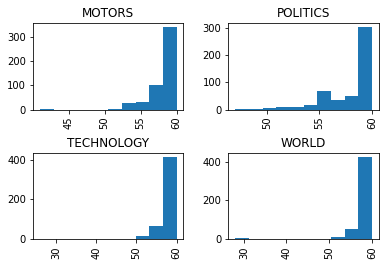

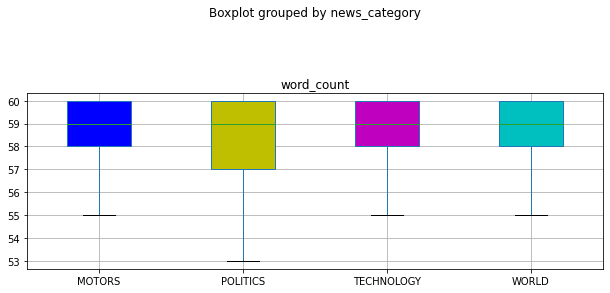

In [152]:
util.explore(df)
print('Data appears uniform, equal number of articles per category and equal average word count per article\n')

print('Report any empty fields :')
df.isnull().sum()

### Data pre-processing

In [153]:
# Clean dataset
# Remove possessive pronoun terminations, punctuation characters, digits, whitespace, change all characters to lower case, lemmatise, and convert categories to number codes
# group_method='Lemmatise'
group_method='Stem'
df, cat_dic = util.pre_process_text(df, group_method)
df[['parsed_news_headline','parsed_news_article','news_category_code']].head()
# Save cleaned / pre-processed dataframe
df_R00207204.to_csv(f'data/{STUDENT_ID}_processed.csv', index=False, header=False)

Pre-processing data...


In [154]:
# Feature selection
features = ['headline+article', 'headline_only', 'article_only']
df[features[0]] = df['parsed_news_headline'] + df['parsed_news_article']
df[features[1]] = df['parsed_news_headline']
df[features[2]] = df['parsed_news_article']
features_selected = features[2]
# Add to report
f = open('data/results.txt', 'a')
f.write('Features Selected : ' + features_selected + '\n' )
f.close()

In [155]:
# Split the test and training data
X_train, X_test, y_train, y_test = train_test_split(df[features_selected], df['news_category_code'], test_size=0.2, shuffle=True, random_state=8001)

In [156]:
# TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, in preparation for encoding text

# Create TfidfVectorizer object
tfidf = util.vectorise(df)
# Transform text
print('Transforming training data text to vectors...')
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print('Done')

Transforming training data text to vectors...
Done


In [157]:
# Show Transformation Summary Statistics
util.show_transform_summary(features_train, features_test, labels_train, labels_test, tfidf, cat_dic)

TRANSFORMATION SUMMARY STATISTICS 

1. Train Features Shape (1600, 300) 

2. Test Features Shape (400, 300) 

3. Vocabulary : Index (first 5 only) [('us', 280), ('lik', 145), ('gen', 112), ('new', 177), ('stat', 252)] 

4. IDF word scores (first 5 only)
 [3.97166447 4.35303202 4.28403915 3.94756691 2.51191566]

5. Chi squared test for unigrams and bigrams most correlated with each category - compare results to category expectations
# 'MOTORS'
  elon, mot, vehic, car, tesl
  elon musk, elect vehic
# 'POLITICS'
  cm, party, farm, congress, bjp
  west beng, congress lead
# 'TECHNOLOGY'
  technolog, amazon, ap, facebook, googl
  west beng, congress lead
# 'WORLD'
  ir, russ, vaccin, trump, coronavir
  donald trump, presid donald




#### Create multi-class classification models x 3 to classify news article categories using sample data provided to train & test models

## 4.1 Load & Use Model : KNN
#### K value (n_neighbor) is the main KNN hyperparameter - plot K v model accuracy and calculate best value

Maximum accuracy:- 0.84 at K = 0


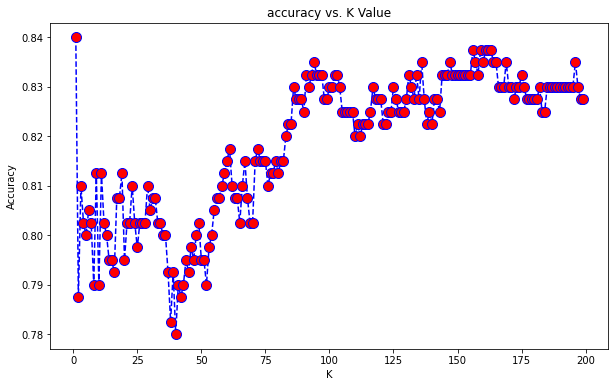

In [158]:
# Visualize the plot between accuracy and K value
acc = []
for i in range(1,200):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(features_train,labels_train)
    yhat = neigh.predict(features_test)
    acc.append(accuracy_score(labels_test, yhat))

plt.figure(figsize=(10,6))
plt.plot(range(1,200),acc,color = 'blue',linestyle='dashed',
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [159]:
# Create base model
model_knn = KNeighborsClassifier()
# Inspect hyperparameters
print('Default Parameters :\n')
cpprint(model_knn.get_params())

# Exhaustive Grid Search Cross Validation
# Set hyperparameters
# initial param_grid = {'n_neighbors':list(range(1,50)[::5]), 'weights':['uniform','distance'], 'metric':['euclidean','manhattan','minkowski']}
param_grid = {'metric': ['euclidean'], 'n_neighbors': [38], 'weights': ['distance']}
# Grid Search
cv = 5 # cv = ShuffleSplit(n_splits = 5, test_size = .2, random_state = 8001)
grid_search = util.create_grid_search_base_model(cv, model_knn, param_grid, features_train, labels_train)
# Create model with best hyperparameters
best_model = grid_search.best_estimator_
# Add to report
f = open('data/results.txt', 'a')
f.write('GridSearchCV best hyperparameters : ' + '\n' )
f.write(str(best_model))
f.close()
df_results = [grid_search.cv_results_]

Default Parameters :

{
    'algorithm': 'auto',
    'leaf_size': 30,
    'metric': 'minkowski',
    'metric_params': None,
    'n_jobs': None,
    'n_neighbors': 5,
    'p': 2,
    'weights': 'uniform'
}
Fitting GridSearch to data...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Duration : 0.1 (s)
Model Mean Accuracy : 83.625 %
Best hyperparameters : {'metric': 'euclidean', 'n_neighbors': 38, 'weights': 'distance'}



Fitting best model to training data...
Model : KNeighborsClassifier(metric='euclidean', n_neighbors=38, weights='distance')
 Model Training Accuracy : 98.375%
 Model Test Accuracy : 83.0%
 Classification report
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       103
           1       0.81      0.96      0.88        94
           2       0.87      0.62      0.72       108
           3       0.91      0.94      0.92        95

    accuracy                           0.83       400
   macro avg       0.84      0.84      0.83       400
weighted avg       0.84      0.83      0.83       400

0.1 (s)


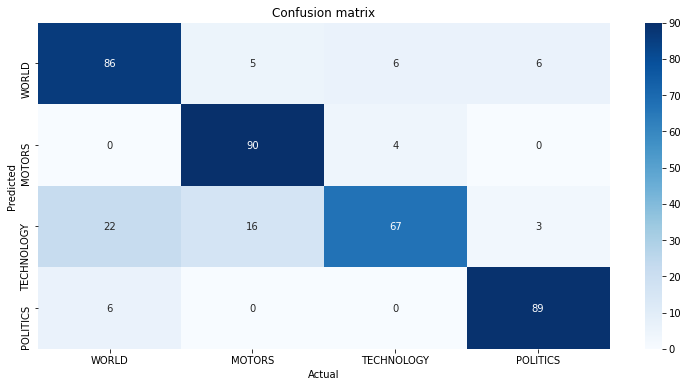

data8001 initialised ...
model and transformations saved...


In [160]:
# Fit and test model
model_knn = util.fit_test_model(best_model, features_train, labels_train, features_test, labels_test, df)
# Save model
model_trans = util.Data8001([tfidf], model_knn)
pickle.dump(model_trans, open(f'model/R00207204_model_1.pkl', 'wb'))
print("model and transformations saved...")

## 4.2 Load & Use Model : Support Vector Machine

In [161]:
# Create base model
model_svm = svm.SVC(random_state=8001)
# Inspect hyperparameters
print('Default Parameters :')
cpprint(model_svm.get_params())

# Exhaustive Grid Search Cross Validation

# Set hyperparameters
# initial param_grid = {'C': [0.0001, 0.001, 0.01], 'degree': [1, 2, 3, 4, 5], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'probability': [True]}
param_grid = {'C': [0.0001], 'degree': [2], 'gamma': [100], 'kernel': ['poly'], 'probability': [True]}
cv = 5 # cv = ShuffleSplit(n_splits = 5, test_size = .2, random_state = 8001)
grid_search = util.create_grid_search_base_model(cv, model_svm, param_grid, features_train, labels_train)
# Create model with best hyperparameters
best_model = grid_search.best_estimator_
# Add to report
f = open('data/results.txt', 'a')
f.write('GridSearchCV best hyperparameters : ' + '\n' )
f.write(str(best_model))
f.close()
df_results = [grid_search.cv_results_]

Default Parameters :
{
    'C': 1.0,
    'break_ties': False,
    'cache_size': 200,
    'class_weight': None,
    'coef0': 0.0,
    'decision_function_shape': 'ovr',
    'degree': 3,
    'gamma': 'scale',
    'kernel': 'rbf',
    'max_iter': -1,
    'probability': False,
    'random_state': 8001,
    'shrinking': True,
    'tol': 0.001,
    'verbose': False
}
Fitting GridSearch to data...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Duration : 9.7 (s)
Model Mean Accuracy : 87.0 %
Best hyperparameters : {'C': 0.0001, 'degree': 2, 'gamma': 100, 'kernel': 'poly', 'probability': True}



Fitting best model to training data...
Model : SVC(C=0.0001, degree=2, gamma=100, kernel='poly', probability=True,
    random_state=8001)
 Model Training Accuracy : 97.4375%
 Model Test Accuracy : 89.5%
 Classification report
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       103
           1       0.92      0.96      0.94        94
           2       0.88      0.78      0.82       108
           3       0.99      0.93      0.96        95

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.89       400

2.5 (s)


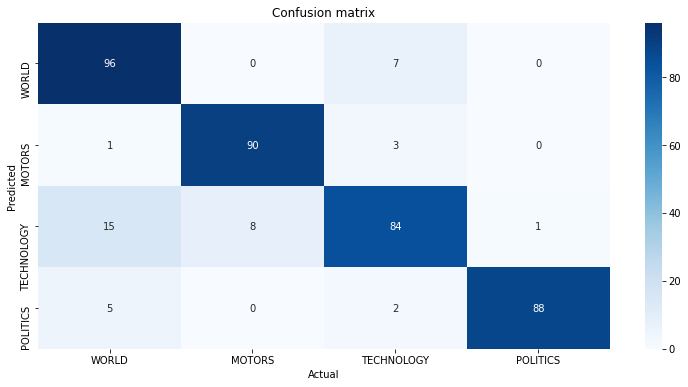

data8001 initialised ...
model and transformations saved...


In [162]:
# Fit and test model
model_svm = util.fit_test_model(best_model, features_train, labels_train, features_test, labels_test, df)
# Save model
model_trans = util.Data8001([tfidf], model_svm)
pickle.dump(model_trans, open(f'model/R00207204_model_2.pkl', 'wb'))
print("model and transformations saved...")

## 4.3 Load & Use Model : Multinomial Naïve Bayes


Fitting best model to training data...
Model : MultinomialNB()
 Model Training Accuracy : 86.9375%
 Model Test Accuracy : 86.0%
 Classification report
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       103
           1       0.83      0.97      0.89        94
           2       0.88      0.70      0.78       108
           3       0.93      0.93      0.93        95

    accuracy                           0.86       400
   macro avg       0.86      0.87      0.86       400
weighted avg       0.86      0.86      0.86       400

0.0 (s)


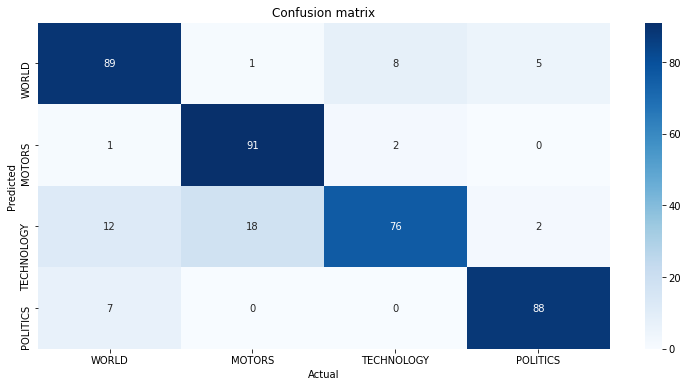

data8001 initialised ...
Model and transformations saved...


In [163]:
# Naive Bayes has almost no hyperparameters to tune and generalises well
best_model = MultinomialNB()

# Fit and test model
model_mbn = util.fit_test_model(best_model, features_train, labels_train, features_test, labels_test, df)
# Save model
model_trans = util.Data8001([tfidf], model_mbn)
pickle.dump(model_trans, open(f'model/R00207204_model_3.pkl', 'wb'))
print("Model and transformations saved...")

In [164]:

# Test features
news_headline = 'Canada administers first doses of Pfizer coronavirus vaccine'
news_article = 'Canada began the vaccination drive against coronavirus with Pfizer/BioNTech doses on Monday by injecting frontline workers and elderly nursing home residents. Anita Quidangen, a personal support worker at the Rekai Centre, was the first person to get vaccinated. She took the vaccine on live television. Canada is the third country after the UK and US to administer the Pfizer/BioNTech vaccine.'
models = ['model_1', 'model_2', 'model_3']

# Test Model 1, 2, 3
for model in models:
    R00207204_model, news_category = util.load_run_model(model_id=model, student_id=STUDENT_ID, news_headline=news_headline, news_article=news_article)
    print(news_category, '- predicted Category by Model :', R00207204_model,'\n')


Loading and running the model_1 for R00207204...
Pre-processing data...
Transforming text to vectors...
Predicting category...
WORLD - predicted Category by Model : KNeighborsClassifier(metric='euclidean', n_neighbors=38, weights='distance') 

Loading and running the model_2 for R00207204...
Pre-processing data...
Transforming text to vectors...
Predicting category...
WORLD - predicted Category by Model : SVC(C=0.0001, degree=2, gamma=100, kernel='poly', probability=True,
    random_state=8001) 

Loading and running the model_3 for R00207204...
Pre-processing data...
Transforming text to vectors...
Predicting category...
WORLD - predicted Category by Model : MultinomialNB() 

